# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

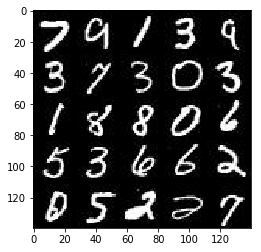

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

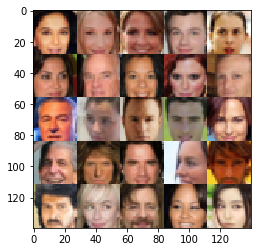

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name = 'inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return (inputs_real, inputs_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def leaky_relu(x, alpha=0.2, name='leaky_relu'):
    tf.maximum(x, alpha * x, name=name)
    
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.01
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        #x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #relu1 = leaky_relu(x1, alpha=0.01)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #relu2 = leaky_relu(bn2, alpha=0.01)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #relu3 = leaky_relu(bn3, alpha=0.01)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
                
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.01
        h1 = tf.layers.dense(z, out_channel_dim, activation=None)
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #x1 = leaky_relu(x1, alpha=0.01)
        # 4x4x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # x2 = leaky_relu(x2, alpha = 0.01)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        #x3 = leaky_relu(x3, alpha = 0.01)
        x3 = tf.maximum(alpha*x3, x3)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Generator network here
    g_model = generator(input_z, out_channel_dim, is_train=True)
    # g_model is the generator output

    # Disriminator network here
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate losses
    smooth = 0.1
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                        labels=tf.ones_like(d_logits_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                        labels=tf.zeros_like(d_logits_real)))
    
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake)))
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """ 
    #model_inputs(image_width, image_height, image_channels, z_dim):
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            i = 0
            for batch_images in get_batches(batch_size):
                i += 1
                # TODO: Train Model
                batch_images = batch_images * 2.0
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                
                
                if i % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                if i % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{} - Batch {}/{}: ".format(epoch_i+1, epoch_count, i, data_shape[0]//batch_size),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))    


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [12]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print(mnist_dataset.shape)


(60000, 28, 28, 1)


Epoch 1/2 - Batch 10/1875:  Discriminator Loss: 4.3375... Generator Loss: 17.4294
Epoch 1/2 - Batch 20/1875:  Discriminator Loss: 0.5712... Generator Loss: 12.1433
Epoch 1/2 - Batch 30/1875:  Discriminator Loss: 2.9184... Generator Loss: 10.8753
Epoch 1/2 - Batch 40/1875:  Discriminator Loss: 0.6460... Generator Loss: 1.6164
Epoch 1/2 - Batch 50/1875:  Discriminator Loss: 0.5701... Generator Loss: 5.7200
Epoch 1/2 - Batch 60/1875:  Discriminator Loss: 1.2599... Generator Loss: 9.4712
Epoch 1/2 - Batch 70/1875:  Discriminator Loss: 0.5121... Generator Loss: 2.2988
Epoch 1/2 - Batch 80/1875:  Discriminator Loss: 0.4571... Generator Loss: 3.5573
Epoch 1/2 - Batch 90/1875:  Discriminator Loss: 0.4588... Generator Loss: 2.9558


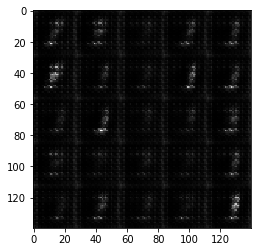

Epoch 1/2 - Batch 100/1875:  Discriminator Loss: 1.6677... Generator Loss: 0.4153
Epoch 1/2 - Batch 110/1875:  Discriminator Loss: 0.6446... Generator Loss: 2.3975
Epoch 1/2 - Batch 120/1875:  Discriminator Loss: 0.6900... Generator Loss: 1.6061
Epoch 1/2 - Batch 130/1875:  Discriminator Loss: 1.1157... Generator Loss: 0.9096
Epoch 1/2 - Batch 140/1875:  Discriminator Loss: 0.8478... Generator Loss: 1.5883
Epoch 1/2 - Batch 150/1875:  Discriminator Loss: 0.6236... Generator Loss: 4.0002
Epoch 1/2 - Batch 160/1875:  Discriminator Loss: 0.6298... Generator Loss: 2.0524
Epoch 1/2 - Batch 170/1875:  Discriminator Loss: 1.3900... Generator Loss: 0.6518
Epoch 1/2 - Batch 180/1875:  Discriminator Loss: 0.7501... Generator Loss: 2.9127
Epoch 1/2 - Batch 190/1875:  Discriminator Loss: 0.7505... Generator Loss: 1.8417


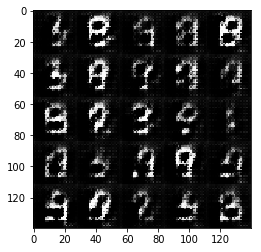

Epoch 1/2 - Batch 200/1875:  Discriminator Loss: 0.7471... Generator Loss: 1.7027
Epoch 1/2 - Batch 210/1875:  Discriminator Loss: 1.4137... Generator Loss: 0.5479
Epoch 1/2 - Batch 220/1875:  Discriminator Loss: 0.7093... Generator Loss: 1.8006
Epoch 1/2 - Batch 230/1875:  Discriminator Loss: 0.9860... Generator Loss: 1.2217
Epoch 1/2 - Batch 240/1875:  Discriminator Loss: 0.7336... Generator Loss: 1.4280
Epoch 1/2 - Batch 250/1875:  Discriminator Loss: 0.9000... Generator Loss: 1.3921
Epoch 1/2 - Batch 260/1875:  Discriminator Loss: 0.7113... Generator Loss: 1.5738
Epoch 1/2 - Batch 270/1875:  Discriminator Loss: 0.9272... Generator Loss: 1.2976
Epoch 1/2 - Batch 280/1875:  Discriminator Loss: 0.7745... Generator Loss: 2.2173
Epoch 1/2 - Batch 290/1875:  Discriminator Loss: 1.2914... Generator Loss: 0.7671


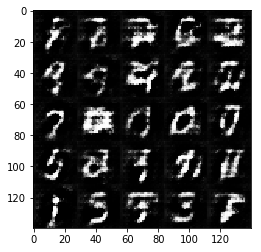

Epoch 1/2 - Batch 300/1875:  Discriminator Loss: 0.9200... Generator Loss: 1.0921
Epoch 1/2 - Batch 310/1875:  Discriminator Loss: 0.9148... Generator Loss: 1.8434
Epoch 1/2 - Batch 320/1875:  Discriminator Loss: 1.0812... Generator Loss: 1.0407
Epoch 1/2 - Batch 330/1875:  Discriminator Loss: 1.5497... Generator Loss: 0.6190
Epoch 1/2 - Batch 340/1875:  Discriminator Loss: 1.6615... Generator Loss: 0.3818
Epoch 1/2 - Batch 350/1875:  Discriminator Loss: 0.9084... Generator Loss: 1.1974
Epoch 1/2 - Batch 360/1875:  Discriminator Loss: 1.8825... Generator Loss: 0.2988
Epoch 1/2 - Batch 370/1875:  Discriminator Loss: 0.9614... Generator Loss: 1.5189
Epoch 1/2 - Batch 380/1875:  Discriminator Loss: 1.3066... Generator Loss: 3.1154
Epoch 1/2 - Batch 390/1875:  Discriminator Loss: 1.1116... Generator Loss: 1.7605


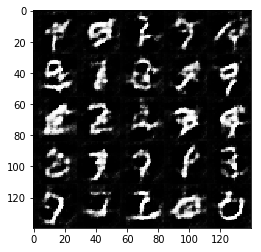

Epoch 1/2 - Batch 400/1875:  Discriminator Loss: 1.1153... Generator Loss: 0.8622
Epoch 1/2 - Batch 410/1875:  Discriminator Loss: 1.0800... Generator Loss: 0.9084
Epoch 1/2 - Batch 420/1875:  Discriminator Loss: 0.9212... Generator Loss: 1.1797
Epoch 1/2 - Batch 430/1875:  Discriminator Loss: 1.3860... Generator Loss: 0.6284
Epoch 1/2 - Batch 440/1875:  Discriminator Loss: 0.9242... Generator Loss: 1.1264
Epoch 1/2 - Batch 450/1875:  Discriminator Loss: 1.0439... Generator Loss: 0.9409
Epoch 1/2 - Batch 460/1875:  Discriminator Loss: 1.8778... Generator Loss: 3.4788
Epoch 1/2 - Batch 470/1875:  Discriminator Loss: 1.3936... Generator Loss: 0.5109
Epoch 1/2 - Batch 480/1875:  Discriminator Loss: 2.0364... Generator Loss: 0.2425
Epoch 1/2 - Batch 490/1875:  Discriminator Loss: 1.2443... Generator Loss: 0.6595


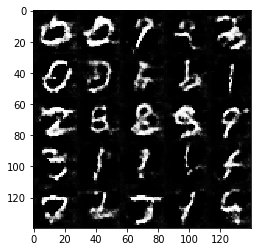

Epoch 1/2 - Batch 500/1875:  Discriminator Loss: 1.0558... Generator Loss: 1.1952
Epoch 1/2 - Batch 510/1875:  Discriminator Loss: 1.0163... Generator Loss: 1.0661
Epoch 1/2 - Batch 520/1875:  Discriminator Loss: 1.0537... Generator Loss: 0.9436
Epoch 1/2 - Batch 530/1875:  Discriminator Loss: 1.1447... Generator Loss: 0.8698
Epoch 1/2 - Batch 540/1875:  Discriminator Loss: 0.9771... Generator Loss: 0.9705
Epoch 1/2 - Batch 550/1875:  Discriminator Loss: 1.3087... Generator Loss: 0.7068
Epoch 1/2 - Batch 560/1875:  Discriminator Loss: 0.9275... Generator Loss: 1.4679
Epoch 1/2 - Batch 570/1875:  Discriminator Loss: 1.1416... Generator Loss: 1.2041
Epoch 1/2 - Batch 580/1875:  Discriminator Loss: 0.9642... Generator Loss: 1.1615
Epoch 1/2 - Batch 590/1875:  Discriminator Loss: 1.2367... Generator Loss: 1.0105


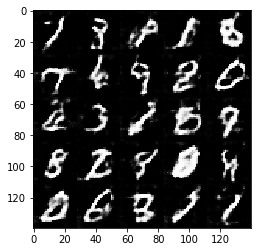

Epoch 1/2 - Batch 600/1875:  Discriminator Loss: 0.8650... Generator Loss: 1.9319
Epoch 1/2 - Batch 610/1875:  Discriminator Loss: 0.9764... Generator Loss: 1.3752
Epoch 1/2 - Batch 620/1875:  Discriminator Loss: 1.3022... Generator Loss: 0.5713
Epoch 1/2 - Batch 630/1875:  Discriminator Loss: 0.8307... Generator Loss: 1.2575
Epoch 1/2 - Batch 640/1875:  Discriminator Loss: 1.4298... Generator Loss: 0.5395
Epoch 1/2 - Batch 650/1875:  Discriminator Loss: 2.2883... Generator Loss: 0.2268
Epoch 1/2 - Batch 660/1875:  Discriminator Loss: 0.9106... Generator Loss: 1.0684
Epoch 1/2 - Batch 670/1875:  Discriminator Loss: 0.9417... Generator Loss: 1.0827
Epoch 1/2 - Batch 680/1875:  Discriminator Loss: 1.0593... Generator Loss: 2.2964
Epoch 1/2 - Batch 690/1875:  Discriminator Loss: 1.0760... Generator Loss: 1.9485


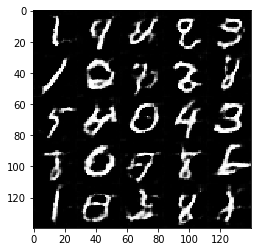

Epoch 1/2 - Batch 700/1875:  Discriminator Loss: 1.0537... Generator Loss: 1.7736
Epoch 1/2 - Batch 710/1875:  Discriminator Loss: 1.0533... Generator Loss: 2.0665
Epoch 1/2 - Batch 720/1875:  Discriminator Loss: 1.3730... Generator Loss: 0.5623
Epoch 1/2 - Batch 730/1875:  Discriminator Loss: 0.8944... Generator Loss: 2.1145
Epoch 1/2 - Batch 740/1875:  Discriminator Loss: 1.5747... Generator Loss: 2.7911
Epoch 1/2 - Batch 750/1875:  Discriminator Loss: 1.2555... Generator Loss: 0.6582
Epoch 1/2 - Batch 760/1875:  Discriminator Loss: 1.8917... Generator Loss: 0.3158
Epoch 1/2 - Batch 770/1875:  Discriminator Loss: 0.8834... Generator Loss: 1.5433
Epoch 1/2 - Batch 780/1875:  Discriminator Loss: 1.7005... Generator Loss: 0.4570
Epoch 1/2 - Batch 790/1875:  Discriminator Loss: 1.8903... Generator Loss: 0.3417


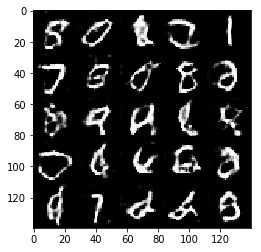

Epoch 1/2 - Batch 800/1875:  Discriminator Loss: 1.0498... Generator Loss: 1.4566
Epoch 1/2 - Batch 810/1875:  Discriminator Loss: 1.1150... Generator Loss: 0.7847
Epoch 1/2 - Batch 820/1875:  Discriminator Loss: 1.3296... Generator Loss: 0.5875
Epoch 1/2 - Batch 830/1875:  Discriminator Loss: 0.9667... Generator Loss: 1.1238
Epoch 1/2 - Batch 840/1875:  Discriminator Loss: 1.4798... Generator Loss: 0.5859
Epoch 1/2 - Batch 850/1875:  Discriminator Loss: 0.9716... Generator Loss: 1.8741
Epoch 1/2 - Batch 860/1875:  Discriminator Loss: 1.3299... Generator Loss: 0.5704
Epoch 1/2 - Batch 870/1875:  Discriminator Loss: 0.9997... Generator Loss: 1.1665
Epoch 1/2 - Batch 880/1875:  Discriminator Loss: 1.5732... Generator Loss: 0.4517
Epoch 1/2 - Batch 890/1875:  Discriminator Loss: 0.8837... Generator Loss: 1.6349


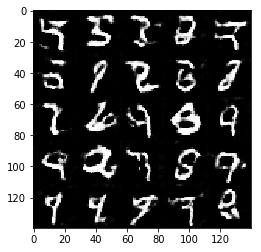

Epoch 1/2 - Batch 900/1875:  Discriminator Loss: 0.8506... Generator Loss: 1.5396
Epoch 1/2 - Batch 910/1875:  Discriminator Loss: 0.9341... Generator Loss: 1.1900
Epoch 1/2 - Batch 920/1875:  Discriminator Loss: 1.0701... Generator Loss: 0.8835
Epoch 1/2 - Batch 930/1875:  Discriminator Loss: 0.9626... Generator Loss: 1.1565
Epoch 1/2 - Batch 940/1875:  Discriminator Loss: 0.9294... Generator Loss: 1.7488
Epoch 1/2 - Batch 950/1875:  Discriminator Loss: 0.9333... Generator Loss: 1.2202
Epoch 1/2 - Batch 960/1875:  Discriminator Loss: 1.4403... Generator Loss: 0.5211
Epoch 1/2 - Batch 970/1875:  Discriminator Loss: 0.9669... Generator Loss: 1.2759
Epoch 1/2 - Batch 980/1875:  Discriminator Loss: 1.3415... Generator Loss: 1.9872
Epoch 1/2 - Batch 990/1875:  Discriminator Loss: 1.2628... Generator Loss: 0.6227


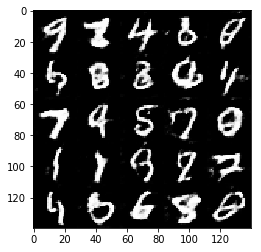

Epoch 1/2 - Batch 1000/1875:  Discriminator Loss: 0.9034... Generator Loss: 1.4673
Epoch 1/2 - Batch 1010/1875:  Discriminator Loss: 0.7993... Generator Loss: 1.4706
Epoch 1/2 - Batch 1020/1875:  Discriminator Loss: 1.2164... Generator Loss: 2.0317
Epoch 1/2 - Batch 1030/1875:  Discriminator Loss: 1.2358... Generator Loss: 0.8427
Epoch 1/2 - Batch 1040/1875:  Discriminator Loss: 1.1454... Generator Loss: 0.7079
Epoch 1/2 - Batch 1050/1875:  Discriminator Loss: 1.1104... Generator Loss: 0.8760
Epoch 1/2 - Batch 1060/1875:  Discriminator Loss: 1.1958... Generator Loss: 2.7589
Epoch 1/2 - Batch 1070/1875:  Discriminator Loss: 1.0846... Generator Loss: 0.8009
Epoch 1/2 - Batch 1080/1875:  Discriminator Loss: 1.7383... Generator Loss: 0.3494
Epoch 1/2 - Batch 1090/1875:  Discriminator Loss: 0.9687... Generator Loss: 1.1686


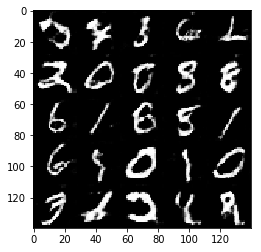

Epoch 1/2 - Batch 1100/1875:  Discriminator Loss: 1.0356... Generator Loss: 1.2437
Epoch 1/2 - Batch 1110/1875:  Discriminator Loss: 1.1236... Generator Loss: 0.9993
Epoch 1/2 - Batch 1120/1875:  Discriminator Loss: 1.2369... Generator Loss: 2.6016
Epoch 1/2 - Batch 1130/1875:  Discriminator Loss: 1.4097... Generator Loss: 0.5790
Epoch 1/2 - Batch 1140/1875:  Discriminator Loss: 0.9251... Generator Loss: 1.0194
Epoch 1/2 - Batch 1150/1875:  Discriminator Loss: 1.1142... Generator Loss: 0.9227
Epoch 1/2 - Batch 1160/1875:  Discriminator Loss: 2.1213... Generator Loss: 0.2425
Epoch 1/2 - Batch 1170/1875:  Discriminator Loss: 1.0603... Generator Loss: 0.9024
Epoch 1/2 - Batch 1180/1875:  Discriminator Loss: 1.1470... Generator Loss: 1.2062
Epoch 1/2 - Batch 1190/1875:  Discriminator Loss: 0.9344... Generator Loss: 1.4311


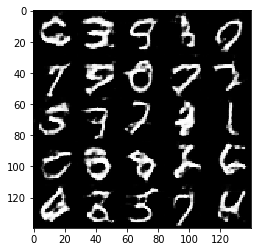

Epoch 1/2 - Batch 1200/1875:  Discriminator Loss: 1.4713... Generator Loss: 0.5018
Epoch 1/2 - Batch 1210/1875:  Discriminator Loss: 1.4062... Generator Loss: 0.5137
Epoch 1/2 - Batch 1220/1875:  Discriminator Loss: 1.3747... Generator Loss: 0.5800
Epoch 1/2 - Batch 1230/1875:  Discriminator Loss: 1.5938... Generator Loss: 0.4043
Epoch 1/2 - Batch 1240/1875:  Discriminator Loss: 0.7991... Generator Loss: 1.3991
Epoch 1/2 - Batch 1250/1875:  Discriminator Loss: 0.9171... Generator Loss: 1.1618
Epoch 1/2 - Batch 1260/1875:  Discriminator Loss: 1.0297... Generator Loss: 0.8061
Epoch 1/2 - Batch 1270/1875:  Discriminator Loss: 0.9849... Generator Loss: 0.9254
Epoch 1/2 - Batch 1280/1875:  Discriminator Loss: 0.8410... Generator Loss: 2.2752
Epoch 1/2 - Batch 1290/1875:  Discriminator Loss: 1.9399... Generator Loss: 0.3112


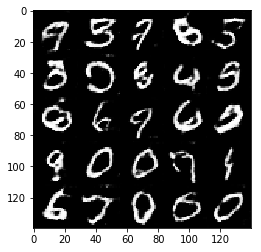

Epoch 1/2 - Batch 1300/1875:  Discriminator Loss: 0.9560... Generator Loss: 0.9694
Epoch 1/2 - Batch 1310/1875:  Discriminator Loss: 1.1596... Generator Loss: 0.7134
Epoch 1/2 - Batch 1320/1875:  Discriminator Loss: 1.0310... Generator Loss: 1.3034
Epoch 1/2 - Batch 1330/1875:  Discriminator Loss: 1.4803... Generator Loss: 0.4566
Epoch 1/2 - Batch 1340/1875:  Discriminator Loss: 0.9518... Generator Loss: 1.0316
Epoch 1/2 - Batch 1350/1875:  Discriminator Loss: 0.8758... Generator Loss: 1.8984
Epoch 1/2 - Batch 1360/1875:  Discriminator Loss: 1.7359... Generator Loss: 0.3973
Epoch 1/2 - Batch 1370/1875:  Discriminator Loss: 0.9548... Generator Loss: 1.2147
Epoch 1/2 - Batch 1380/1875:  Discriminator Loss: 0.9318... Generator Loss: 1.1694
Epoch 1/2 - Batch 1390/1875:  Discriminator Loss: 1.3761... Generator Loss: 0.6286


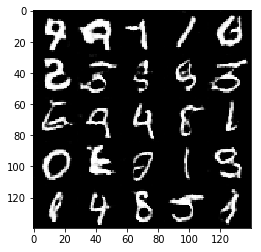

Epoch 1/2 - Batch 1400/1875:  Discriminator Loss: 1.2502... Generator Loss: 0.6813
Epoch 1/2 - Batch 1410/1875:  Discriminator Loss: 1.2618... Generator Loss: 0.6322
Epoch 1/2 - Batch 1420/1875:  Discriminator Loss: 0.7485... Generator Loss: 1.2780
Epoch 1/2 - Batch 1430/1875:  Discriminator Loss: 0.8603... Generator Loss: 1.1038
Epoch 1/2 - Batch 1440/1875:  Discriminator Loss: 1.9293... Generator Loss: 0.2958
Epoch 1/2 - Batch 1450/1875:  Discriminator Loss: 1.3900... Generator Loss: 0.7091
Epoch 1/2 - Batch 1460/1875:  Discriminator Loss: 1.1374... Generator Loss: 0.7595
Epoch 1/2 - Batch 1470/1875:  Discriminator Loss: 1.1756... Generator Loss: 2.5788
Epoch 1/2 - Batch 1480/1875:  Discriminator Loss: 2.0776... Generator Loss: 0.2844
Epoch 1/2 - Batch 1490/1875:  Discriminator Loss: 0.8638... Generator Loss: 1.2125


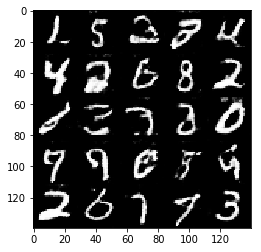

Epoch 1/2 - Batch 1500/1875:  Discriminator Loss: 0.9436... Generator Loss: 1.0204
Epoch 1/2 - Batch 1510/1875:  Discriminator Loss: 0.8964... Generator Loss: 1.6474
Epoch 1/2 - Batch 1520/1875:  Discriminator Loss: 1.1883... Generator Loss: 0.7648
Epoch 1/2 - Batch 1530/1875:  Discriminator Loss: 0.8725... Generator Loss: 1.3826
Epoch 1/2 - Batch 1540/1875:  Discriminator Loss: 1.0028... Generator Loss: 0.9419
Epoch 1/2 - Batch 1550/1875:  Discriminator Loss: 1.0812... Generator Loss: 0.8793
Epoch 1/2 - Batch 1560/1875:  Discriminator Loss: 0.9992... Generator Loss: 0.9005
Epoch 1/2 - Batch 1570/1875:  Discriminator Loss: 1.2186... Generator Loss: 0.6480
Epoch 1/2 - Batch 1580/1875:  Discriminator Loss: 0.8480... Generator Loss: 1.4889
Epoch 1/2 - Batch 1590/1875:  Discriminator Loss: 1.2393... Generator Loss: 0.6283


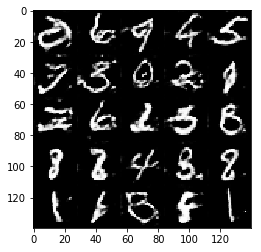

Epoch 1/2 - Batch 1600/1875:  Discriminator Loss: 1.3805... Generator Loss: 0.5826
Epoch 1/2 - Batch 1610/1875:  Discriminator Loss: 1.2152... Generator Loss: 0.6885
Epoch 1/2 - Batch 1620/1875:  Discriminator Loss: 1.1183... Generator Loss: 0.7678
Epoch 1/2 - Batch 1630/1875:  Discriminator Loss: 1.0156... Generator Loss: 0.9470
Epoch 1/2 - Batch 1640/1875:  Discriminator Loss: 0.8677... Generator Loss: 1.2057
Epoch 1/2 - Batch 1650/1875:  Discriminator Loss: 0.9133... Generator Loss: 1.1188
Epoch 1/2 - Batch 1660/1875:  Discriminator Loss: 0.8656... Generator Loss: 1.1485
Epoch 1/2 - Batch 1670/1875:  Discriminator Loss: 1.3484... Generator Loss: 0.5552
Epoch 1/2 - Batch 1680/1875:  Discriminator Loss: 1.2225... Generator Loss: 2.2511
Epoch 1/2 - Batch 1690/1875:  Discriminator Loss: 0.9160... Generator Loss: 0.9966


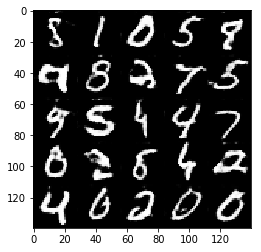

Epoch 1/2 - Batch 1700/1875:  Discriminator Loss: 1.6287... Generator Loss: 0.4031
Epoch 1/2 - Batch 1710/1875:  Discriminator Loss: 1.4774... Generator Loss: 0.6839
Epoch 1/2 - Batch 1720/1875:  Discriminator Loss: 1.0716... Generator Loss: 0.7683
Epoch 1/2 - Batch 1730/1875:  Discriminator Loss: 0.8054... Generator Loss: 1.2492
Epoch 1/2 - Batch 1740/1875:  Discriminator Loss: 0.6576... Generator Loss: 2.0138
Epoch 1/2 - Batch 1750/1875:  Discriminator Loss: 1.2537... Generator Loss: 0.5897
Epoch 1/2 - Batch 1760/1875:  Discriminator Loss: 0.9363... Generator Loss: 1.1966
Epoch 1/2 - Batch 1770/1875:  Discriminator Loss: 1.3491... Generator Loss: 2.9506
Epoch 1/2 - Batch 1780/1875:  Discriminator Loss: 0.9125... Generator Loss: 0.9829
Epoch 1/2 - Batch 1790/1875:  Discriminator Loss: 0.9626... Generator Loss: 0.9523


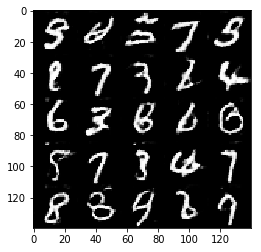

Epoch 1/2 - Batch 1800/1875:  Discriminator Loss: 0.7664... Generator Loss: 1.2633
Epoch 1/2 - Batch 1810/1875:  Discriminator Loss: 1.3999... Generator Loss: 0.5964
Epoch 1/2 - Batch 1820/1875:  Discriminator Loss: 0.8252... Generator Loss: 1.4997
Epoch 1/2 - Batch 1830/1875:  Discriminator Loss: 0.8476... Generator Loss: 1.3079
Epoch 1/2 - Batch 1840/1875:  Discriminator Loss: 1.2917... Generator Loss: 1.6559
Epoch 1/2 - Batch 1850/1875:  Discriminator Loss: 0.7942... Generator Loss: 1.9148
Epoch 1/2 - Batch 1860/1875:  Discriminator Loss: 0.8675... Generator Loss: 1.1838
Epoch 1/2 - Batch 1870/1875:  Discriminator Loss: 1.3887... Generator Loss: 0.5805
Epoch 2/2 - Batch 10/1875:  Discriminator Loss: 1.0466... Generator Loss: 0.8596
Epoch 2/2 - Batch 20/1875:  Discriminator Loss: 0.9882... Generator Loss: 0.9723
Epoch 2/2 - Batch 30/1875:  Discriminator Loss: 1.1509... Generator Loss: 3.3595
Epoch 2/2 - Batch 40/1875:  Discriminator Loss: 1.2353... Generator Loss: 0.8204
Epoch 2/2 - 

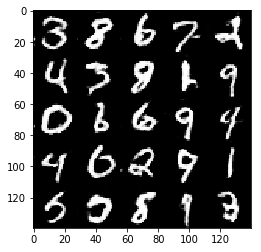

Epoch 2/2 - Batch 100/1875:  Discriminator Loss: 1.0015... Generator Loss: 1.0333
Epoch 2/2 - Batch 110/1875:  Discriminator Loss: 1.1657... Generator Loss: 2.4984
Epoch 2/2 - Batch 120/1875:  Discriminator Loss: 0.9281... Generator Loss: 1.1147
Epoch 2/2 - Batch 130/1875:  Discriminator Loss: 1.0452... Generator Loss: 0.8770
Epoch 2/2 - Batch 140/1875:  Discriminator Loss: 0.8756... Generator Loss: 1.0562
Epoch 2/2 - Batch 150/1875:  Discriminator Loss: 0.9992... Generator Loss: 0.9069
Epoch 2/2 - Batch 160/1875:  Discriminator Loss: 1.4492... Generator Loss: 3.6261
Epoch 2/2 - Batch 170/1875:  Discriminator Loss: 1.0696... Generator Loss: 0.9655
Epoch 2/2 - Batch 180/1875:  Discriminator Loss: 1.6844... Generator Loss: 0.4242
Epoch 2/2 - Batch 190/1875:  Discriminator Loss: 0.8457... Generator Loss: 1.1673


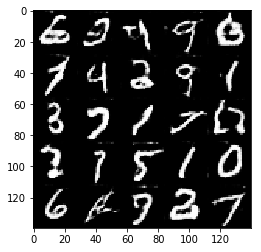

Epoch 2/2 - Batch 200/1875:  Discriminator Loss: 1.1931... Generator Loss: 0.7681
Epoch 2/2 - Batch 210/1875:  Discriminator Loss: 0.8977... Generator Loss: 1.0956
Epoch 2/2 - Batch 220/1875:  Discriminator Loss: 0.9836... Generator Loss: 2.5691
Epoch 2/2 - Batch 230/1875:  Discriminator Loss: 0.9413... Generator Loss: 1.5470
Epoch 2/2 - Batch 240/1875:  Discriminator Loss: 0.8107... Generator Loss: 1.5163
Epoch 2/2 - Batch 250/1875:  Discriminator Loss: 0.9060... Generator Loss: 1.9688
Epoch 2/2 - Batch 260/1875:  Discriminator Loss: 0.9545... Generator Loss: 1.0171
Epoch 2/2 - Batch 270/1875:  Discriminator Loss: 1.1683... Generator Loss: 2.7207
Epoch 2/2 - Batch 280/1875:  Discriminator Loss: 0.7782... Generator Loss: 1.3525
Epoch 2/2 - Batch 290/1875:  Discriminator Loss: 1.0361... Generator Loss: 0.8582


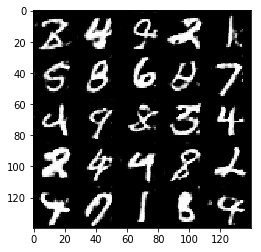

Epoch 2/2 - Batch 300/1875:  Discriminator Loss: 2.1026... Generator Loss: 0.3298
Epoch 2/2 - Batch 310/1875:  Discriminator Loss: 0.7185... Generator Loss: 1.5354
Epoch 2/2 - Batch 320/1875:  Discriminator Loss: 1.6926... Generator Loss: 0.4060
Epoch 2/2 - Batch 330/1875:  Discriminator Loss: 0.7636... Generator Loss: 2.3028
Epoch 2/2 - Batch 340/1875:  Discriminator Loss: 0.8928... Generator Loss: 1.0877
Epoch 2/2 - Batch 350/1875:  Discriminator Loss: 0.7428... Generator Loss: 2.1677
Epoch 2/2 - Batch 360/1875:  Discriminator Loss: 1.3409... Generator Loss: 2.0639
Epoch 2/2 - Batch 370/1875:  Discriminator Loss: 0.8335... Generator Loss: 1.3160
Epoch 2/2 - Batch 380/1875:  Discriminator Loss: 1.4424... Generator Loss: 0.4893
Epoch 2/2 - Batch 390/1875:  Discriminator Loss: 1.0841... Generator Loss: 0.8219


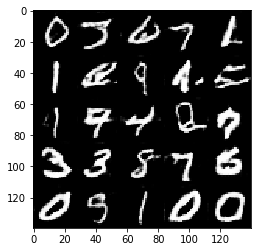

Epoch 2/2 - Batch 400/1875:  Discriminator Loss: 1.2662... Generator Loss: 0.6039
Epoch 2/2 - Batch 410/1875:  Discriminator Loss: 1.0425... Generator Loss: 0.9680
Epoch 2/2 - Batch 420/1875:  Discriminator Loss: 2.0969... Generator Loss: 0.2577
Epoch 2/2 - Batch 430/1875:  Discriminator Loss: 1.1981... Generator Loss: 0.8905
Epoch 2/2 - Batch 440/1875:  Discriminator Loss: 0.7879... Generator Loss: 1.6312
Epoch 2/2 - Batch 450/1875:  Discriminator Loss: 1.5253... Generator Loss: 0.5764
Epoch 2/2 - Batch 460/1875:  Discriminator Loss: 0.9779... Generator Loss: 1.0105
Epoch 2/2 - Batch 470/1875:  Discriminator Loss: 1.4581... Generator Loss: 0.5400
Epoch 2/2 - Batch 480/1875:  Discriminator Loss: 1.3820... Generator Loss: 0.5135
Epoch 2/2 - Batch 490/1875:  Discriminator Loss: 1.0513... Generator Loss: 0.9332


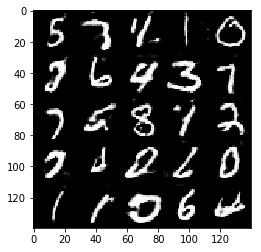

Epoch 2/2 - Batch 500/1875:  Discriminator Loss: 0.9454... Generator Loss: 1.0021
Epoch 2/2 - Batch 510/1875:  Discriminator Loss: 0.7504... Generator Loss: 1.9942
Epoch 2/2 - Batch 520/1875:  Discriminator Loss: 1.3370... Generator Loss: 0.6187
Epoch 2/2 - Batch 530/1875:  Discriminator Loss: 0.6709... Generator Loss: 1.4741
Epoch 2/2 - Batch 540/1875:  Discriminator Loss: 0.8620... Generator Loss: 1.2883
Epoch 2/2 - Batch 550/1875:  Discriminator Loss: 0.8767... Generator Loss: 2.5710
Epoch 2/2 - Batch 560/1875:  Discriminator Loss: 0.7572... Generator Loss: 1.4780
Epoch 2/2 - Batch 570/1875:  Discriminator Loss: 0.9824... Generator Loss: 1.4821
Epoch 2/2 - Batch 580/1875:  Discriminator Loss: 0.8132... Generator Loss: 1.2543
Epoch 2/2 - Batch 590/1875:  Discriminator Loss: 0.8185... Generator Loss: 1.2907


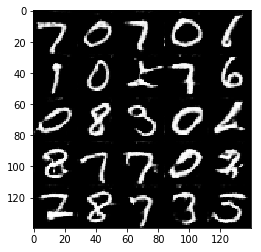

Epoch 2/2 - Batch 600/1875:  Discriminator Loss: 0.6019... Generator Loss: 2.2094
Epoch 2/2 - Batch 610/1875:  Discriminator Loss: 0.7172... Generator Loss: 1.4820
Epoch 2/2 - Batch 620/1875:  Discriminator Loss: 0.8141... Generator Loss: 1.3178
Epoch 2/2 - Batch 630/1875:  Discriminator Loss: 0.7612... Generator Loss: 1.3504
Epoch 2/2 - Batch 640/1875:  Discriminator Loss: 1.5270... Generator Loss: 0.4347
Epoch 2/2 - Batch 650/1875:  Discriminator Loss: 1.3941... Generator Loss: 0.5831
Epoch 2/2 - Batch 660/1875:  Discriminator Loss: 0.8455... Generator Loss: 1.1723
Epoch 2/2 - Batch 670/1875:  Discriminator Loss: 0.8654... Generator Loss: 1.1569
Epoch 2/2 - Batch 680/1875:  Discriminator Loss: 0.9446... Generator Loss: 2.7350
Epoch 2/2 - Batch 690/1875:  Discriminator Loss: 0.7001... Generator Loss: 2.5707


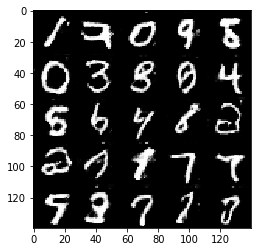

Epoch 2/2 - Batch 700/1875:  Discriminator Loss: 0.7042... Generator Loss: 2.4461
Epoch 2/2 - Batch 710/1875:  Discriminator Loss: 0.6969... Generator Loss: 1.4977
Epoch 2/2 - Batch 720/1875:  Discriminator Loss: 1.3018... Generator Loss: 0.5986
Epoch 2/2 - Batch 730/1875:  Discriminator Loss: 0.6882... Generator Loss: 1.8718
Epoch 2/2 - Batch 740/1875:  Discriminator Loss: 1.6714... Generator Loss: 0.3382
Epoch 2/2 - Batch 750/1875:  Discriminator Loss: 0.7385... Generator Loss: 1.5480
Epoch 2/2 - Batch 760/1875:  Discriminator Loss: 2.4178... Generator Loss: 0.2785
Epoch 2/2 - Batch 770/1875:  Discriminator Loss: 0.8901... Generator Loss: 1.1009
Epoch 2/2 - Batch 780/1875:  Discriminator Loss: 1.7598... Generator Loss: 0.4038
Epoch 2/2 - Batch 790/1875:  Discriminator Loss: 0.8732... Generator Loss: 2.0596


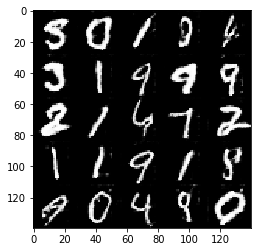

Epoch 2/2 - Batch 800/1875:  Discriminator Loss: 0.7377... Generator Loss: 1.6705
Epoch 2/2 - Batch 810/1875:  Discriminator Loss: 0.7596... Generator Loss: 1.2728
Epoch 2/2 - Batch 820/1875:  Discriminator Loss: 1.0134... Generator Loss: 0.9798
Epoch 2/2 - Batch 830/1875:  Discriminator Loss: 0.9279... Generator Loss: 1.0227
Epoch 2/2 - Batch 840/1875:  Discriminator Loss: 1.3081... Generator Loss: 0.6556
Epoch 2/2 - Batch 850/1875:  Discriminator Loss: 0.8964... Generator Loss: 1.0606
Epoch 2/2 - Batch 860/1875:  Discriminator Loss: 2.1932... Generator Loss: 0.2260
Epoch 2/2 - Batch 870/1875:  Discriminator Loss: 0.7083... Generator Loss: 1.4260
Epoch 2/2 - Batch 880/1875:  Discriminator Loss: 0.5926... Generator Loss: 2.0373
Epoch 2/2 - Batch 890/1875:  Discriminator Loss: 0.9966... Generator Loss: 0.9189


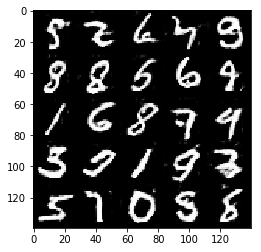

Epoch 2/2 - Batch 900/1875:  Discriminator Loss: 0.6901... Generator Loss: 1.6035
Epoch 2/2 - Batch 910/1875:  Discriminator Loss: 0.7156... Generator Loss: 1.7779
Epoch 2/2 - Batch 920/1875:  Discriminator Loss: 1.3647... Generator Loss: 2.9051
Epoch 2/2 - Batch 930/1875:  Discriminator Loss: 0.8111... Generator Loss: 1.7928
Epoch 2/2 - Batch 940/1875:  Discriminator Loss: 0.6712... Generator Loss: 1.4995
Epoch 2/2 - Batch 950/1875:  Discriminator Loss: 0.9871... Generator Loss: 0.9759
Epoch 2/2 - Batch 960/1875:  Discriminator Loss: 0.8354... Generator Loss: 1.1440
Epoch 2/2 - Batch 970/1875:  Discriminator Loss: 0.8476... Generator Loss: 2.1076
Epoch 2/2 - Batch 980/1875:  Discriminator Loss: 0.9121... Generator Loss: 1.2067
Epoch 2/2 - Batch 990/1875:  Discriminator Loss: 1.0104... Generator Loss: 0.9102


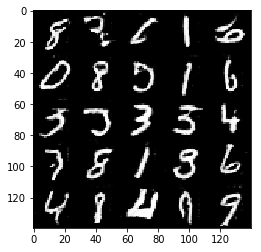

Epoch 2/2 - Batch 1000/1875:  Discriminator Loss: 1.3737... Generator Loss: 0.5292
Epoch 2/2 - Batch 1010/1875:  Discriminator Loss: 0.9039... Generator Loss: 1.0603
Epoch 2/2 - Batch 1020/1875:  Discriminator Loss: 0.7687... Generator Loss: 1.3553
Epoch 2/2 - Batch 1030/1875:  Discriminator Loss: 0.7735... Generator Loss: 1.3989
Epoch 2/2 - Batch 1040/1875:  Discriminator Loss: 0.6131... Generator Loss: 1.7911
Epoch 2/2 - Batch 1050/1875:  Discriminator Loss: 0.8172... Generator Loss: 1.2516
Epoch 2/2 - Batch 1060/1875:  Discriminator Loss: 1.7989... Generator Loss: 0.3253
Epoch 2/2 - Batch 1070/1875:  Discriminator Loss: 0.7156... Generator Loss: 1.5925
Epoch 2/2 - Batch 1080/1875:  Discriminator Loss: 1.5376... Generator Loss: 0.5763
Epoch 2/2 - Batch 1090/1875:  Discriminator Loss: 0.6509... Generator Loss: 1.6763


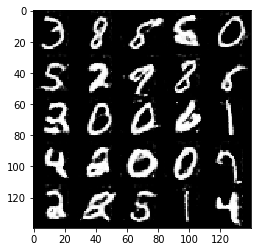

Epoch 2/2 - Batch 1100/1875:  Discriminator Loss: 0.6211... Generator Loss: 1.8553
Epoch 2/2 - Batch 1110/1875:  Discriminator Loss: 0.6598... Generator Loss: 1.6637
Epoch 2/2 - Batch 1120/1875:  Discriminator Loss: 1.7373... Generator Loss: 0.3809
Epoch 2/2 - Batch 1130/1875:  Discriminator Loss: 0.9232... Generator Loss: 1.0275
Epoch 2/2 - Batch 1140/1875:  Discriminator Loss: 1.0788... Generator Loss: 0.9825
Epoch 2/2 - Batch 1150/1875:  Discriminator Loss: 0.7644... Generator Loss: 1.9267
Epoch 2/2 - Batch 1160/1875:  Discriminator Loss: 0.9234... Generator Loss: 1.2132
Epoch 2/2 - Batch 1170/1875:  Discriminator Loss: 0.9705... Generator Loss: 0.9278
Epoch 2/2 - Batch 1180/1875:  Discriminator Loss: 0.8770... Generator Loss: 1.1676
Epoch 2/2 - Batch 1190/1875:  Discriminator Loss: 1.2107... Generator Loss: 0.7431


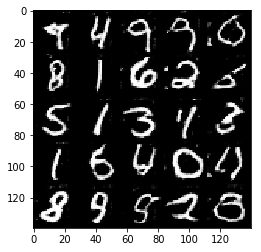

Epoch 2/2 - Batch 1200/1875:  Discriminator Loss: 1.0374... Generator Loss: 0.9472
Epoch 2/2 - Batch 1210/1875:  Discriminator Loss: 1.2436... Generator Loss: 0.7421
Epoch 2/2 - Batch 1220/1875:  Discriminator Loss: 1.4769... Generator Loss: 0.5104
Epoch 2/2 - Batch 1230/1875:  Discriminator Loss: 0.6891... Generator Loss: 1.5691
Epoch 2/2 - Batch 1240/1875:  Discriminator Loss: 0.7272... Generator Loss: 1.4343
Epoch 2/2 - Batch 1250/1875:  Discriminator Loss: 0.7031... Generator Loss: 1.5410
Epoch 2/2 - Batch 1260/1875:  Discriminator Loss: 0.6613... Generator Loss: 1.6058
Epoch 2/2 - Batch 1270/1875:  Discriminator Loss: 0.6476... Generator Loss: 2.2891
Epoch 2/2 - Batch 1280/1875:  Discriminator Loss: 0.5840... Generator Loss: 2.0871
Epoch 2/2 - Batch 1290/1875:  Discriminator Loss: 1.5842... Generator Loss: 0.5800


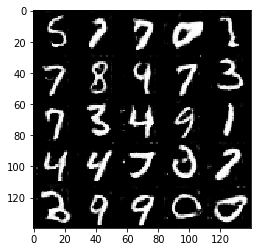

Epoch 2/2 - Batch 1300/1875:  Discriminator Loss: 0.7453... Generator Loss: 1.4039
Epoch 2/2 - Batch 1310/1875:  Discriminator Loss: 0.9475... Generator Loss: 1.0122
Epoch 2/2 - Batch 1320/1875:  Discriminator Loss: 0.6439... Generator Loss: 1.5759
Epoch 2/2 - Batch 1330/1875:  Discriminator Loss: 0.8272... Generator Loss: 1.1284
Epoch 2/2 - Batch 1340/1875:  Discriminator Loss: 1.6422... Generator Loss: 0.4840
Epoch 2/2 - Batch 1350/1875:  Discriminator Loss: 0.9425... Generator Loss: 0.9408
Epoch 2/2 - Batch 1360/1875:  Discriminator Loss: 2.1691... Generator Loss: 0.3743
Epoch 2/2 - Batch 1370/1875:  Discriminator Loss: 1.0265... Generator Loss: 0.8993
Epoch 2/2 - Batch 1380/1875:  Discriminator Loss: 0.7134... Generator Loss: 1.4305
Epoch 2/2 - Batch 1390/1875:  Discriminator Loss: 0.9421... Generator Loss: 1.0457


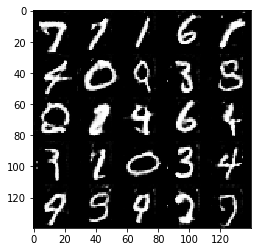

Epoch 2/2 - Batch 1400/1875:  Discriminator Loss: 0.7625... Generator Loss: 1.3368
Epoch 2/2 - Batch 1410/1875:  Discriminator Loss: 1.2849... Generator Loss: 2.3300
Epoch 2/2 - Batch 1420/1875:  Discriminator Loss: 0.6829... Generator Loss: 1.5047
Epoch 2/2 - Batch 1430/1875:  Discriminator Loss: 2.0701... Generator Loss: 0.2818
Epoch 2/2 - Batch 1440/1875:  Discriminator Loss: 2.1445... Generator Loss: 0.2841
Epoch 2/2 - Batch 1450/1875:  Discriminator Loss: 0.9590... Generator Loss: 1.0219
Epoch 2/2 - Batch 1460/1875:  Discriminator Loss: 0.8584... Generator Loss: 2.1502
Epoch 2/2 - Batch 1470/1875:  Discriminator Loss: 0.5024... Generator Loss: 2.4278
Epoch 2/2 - Batch 1480/1875:  Discriminator Loss: 0.8526... Generator Loss: 1.0790
Epoch 2/2 - Batch 1490/1875:  Discriminator Loss: 1.6113... Generator Loss: 3.8651


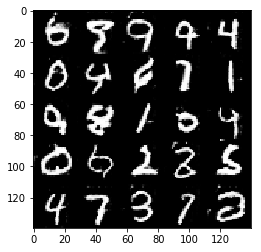

Epoch 2/2 - Batch 1500/1875:  Discriminator Loss: 0.6661... Generator Loss: 1.5918
Epoch 2/2 - Batch 1510/1875:  Discriminator Loss: 0.7734... Generator Loss: 1.3183
Epoch 2/2 - Batch 1520/1875:  Discriminator Loss: 1.0233... Generator Loss: 1.0095
Epoch 2/2 - Batch 1530/1875:  Discriminator Loss: 0.8833... Generator Loss: 1.1139
Epoch 2/2 - Batch 1540/1875:  Discriminator Loss: 0.5823... Generator Loss: 2.4525
Epoch 2/2 - Batch 1550/1875:  Discriminator Loss: 1.4464... Generator Loss: 0.6053
Epoch 2/2 - Batch 1560/1875:  Discriminator Loss: 1.6721... Generator Loss: 0.4413
Epoch 2/2 - Batch 1570/1875:  Discriminator Loss: 0.6587... Generator Loss: 1.6273
Epoch 2/2 - Batch 1580/1875:  Discriminator Loss: 0.8375... Generator Loss: 1.2224
Epoch 2/2 - Batch 1590/1875:  Discriminator Loss: 1.5323... Generator Loss: 0.5350


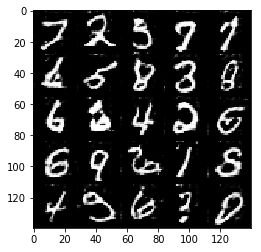

Epoch 2/2 - Batch 1600/1875:  Discriminator Loss: 0.8817... Generator Loss: 3.5001
Epoch 2/2 - Batch 1610/1875:  Discriminator Loss: 0.5557... Generator Loss: 1.9604
Epoch 2/2 - Batch 1620/1875:  Discriminator Loss: 0.9950... Generator Loss: 1.1256
Epoch 2/2 - Batch 1630/1875:  Discriminator Loss: 1.0057... Generator Loss: 0.8743
Epoch 2/2 - Batch 1640/1875:  Discriminator Loss: 0.6742... Generator Loss: 1.6333
Epoch 2/2 - Batch 1650/1875:  Discriminator Loss: 2.8345... Generator Loss: 0.2149
Epoch 2/2 - Batch 1660/1875:  Discriminator Loss: 0.6294... Generator Loss: 1.8754
Epoch 2/2 - Batch 1670/1875:  Discriminator Loss: 0.7338... Generator Loss: 1.4312
Epoch 2/2 - Batch 1680/1875:  Discriminator Loss: 1.1942... Generator Loss: 0.8419
Epoch 2/2 - Batch 1690/1875:  Discriminator Loss: 0.9910... Generator Loss: 0.9767


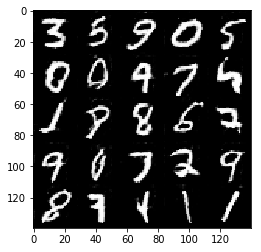

Epoch 2/2 - Batch 1700/1875:  Discriminator Loss: 1.5022... Generator Loss: 0.5889
Epoch 2/2 - Batch 1710/1875:  Discriminator Loss: 1.2018... Generator Loss: 0.8465
Epoch 2/2 - Batch 1720/1875:  Discriminator Loss: 0.6742... Generator Loss: 1.8020
Epoch 2/2 - Batch 1730/1875:  Discriminator Loss: 0.7409... Generator Loss: 1.5374
Epoch 2/2 - Batch 1740/1875:  Discriminator Loss: 0.6945... Generator Loss: 1.8722
Epoch 2/2 - Batch 1750/1875:  Discriminator Loss: 0.8039... Generator Loss: 1.2696
Epoch 2/2 - Batch 1760/1875:  Discriminator Loss: 0.9232... Generator Loss: 1.0586
Epoch 2/2 - Batch 1770/1875:  Discriminator Loss: 0.5250... Generator Loss: 2.0547
Epoch 2/2 - Batch 1780/1875:  Discriminator Loss: 0.6942... Generator Loss: 1.6480
Epoch 2/2 - Batch 1790/1875:  Discriminator Loss: 0.5541... Generator Loss: 2.5340


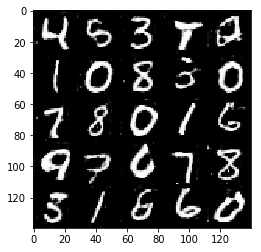

Epoch 2/2 - Batch 1800/1875:  Discriminator Loss: 0.7436... Generator Loss: 1.3369
Epoch 2/2 - Batch 1810/1875:  Discriminator Loss: 0.8509... Generator Loss: 1.3138
Epoch 2/2 - Batch 1820/1875:  Discriminator Loss: 0.9986... Generator Loss: 0.8877
Epoch 2/2 - Batch 1830/1875:  Discriminator Loss: 0.7098... Generator Loss: 1.3961
Epoch 2/2 - Batch 1840/1875:  Discriminator Loss: 0.7240... Generator Loss: 1.3517
Epoch 2/2 - Batch 1850/1875:  Discriminator Loss: 0.5608... Generator Loss: 1.9906
Epoch 2/2 - Batch 1860/1875:  Discriminator Loss: 0.8287... Generator Loss: 1.3297
Epoch 2/2 - Batch 1870/1875:  Discriminator Loss: 1.1558... Generator Loss: 0.7123


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 - Batch 10/6331:  Discriminator Loss: 5.5683... Generator Loss: 0.0080
Epoch 1/1 - Batch 20/6331:  Discriminator Loss: 0.5423... Generator Loss: 13.6975
Epoch 1/1 - Batch 30/6331:  Discriminator Loss: 0.6191... Generator Loss: 1.8075
Epoch 1/1 - Batch 40/6331:  Discriminator Loss: 0.5420... Generator Loss: 12.1525
Epoch 1/1 - Batch 50/6331:  Discriminator Loss: 1.8324... Generator Loss: 0.3283
Epoch 1/1 - Batch 60/6331:  Discriminator Loss: 4.3194... Generator Loss: 0.0254
Epoch 1/1 - Batch 70/6331:  Discriminator Loss: 0.5354... Generator Loss: 7.2741
Epoch 1/1 - Batch 80/6331:  Discriminator Loss: 0.4431... Generator Loss: 3.1131
Epoch 1/1 - Batch 90/6331:  Discriminator Loss: 0.6260... Generator Loss: 2.0373


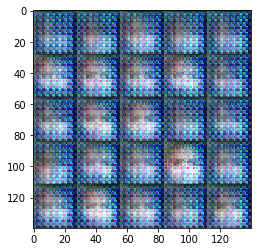

Epoch 1/1 - Batch 100/6331:  Discriminator Loss: 0.5116... Generator Loss: 2.2544
Epoch 1/1 - Batch 110/6331:  Discriminator Loss: 0.7927... Generator Loss: 1.3516
Epoch 1/1 - Batch 120/6331:  Discriminator Loss: 0.8722... Generator Loss: 1.7890
Epoch 1/1 - Batch 130/6331:  Discriminator Loss: 2.1029... Generator Loss: 4.8426
Epoch 1/1 - Batch 140/6331:  Discriminator Loss: 0.7600... Generator Loss: 1.3831
Epoch 1/1 - Batch 150/6331:  Discriminator Loss: 0.8013... Generator Loss: 2.9160
Epoch 1/1 - Batch 160/6331:  Discriminator Loss: 0.7578... Generator Loss: 3.5717
Epoch 1/1 - Batch 170/6331:  Discriminator Loss: 1.0291... Generator Loss: 2.9989
Epoch 1/1 - Batch 180/6331:  Discriminator Loss: 0.6528... Generator Loss: 1.7368
Epoch 1/1 - Batch 190/6331:  Discriminator Loss: 1.2558... Generator Loss: 0.7009


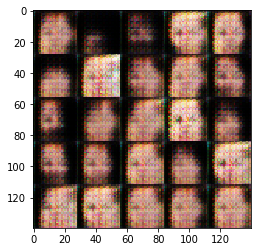

Epoch 1/1 - Batch 200/6331:  Discriminator Loss: 1.5300... Generator Loss: 0.4998
Epoch 1/1 - Batch 210/6331:  Discriminator Loss: 0.7490... Generator Loss: 1.7397
Epoch 1/1 - Batch 220/6331:  Discriminator Loss: 0.8377... Generator Loss: 4.7095
Epoch 1/1 - Batch 230/6331:  Discriminator Loss: 0.7750... Generator Loss: 1.7025
Epoch 1/1 - Batch 240/6331:  Discriminator Loss: 1.3410... Generator Loss: 0.6851
Epoch 1/1 - Batch 250/6331:  Discriminator Loss: 1.3325... Generator Loss: 0.6740
Epoch 1/1 - Batch 260/6331:  Discriminator Loss: 1.0868... Generator Loss: 2.3765
Epoch 1/1 - Batch 270/6331:  Discriminator Loss: 1.0435... Generator Loss: 1.4001
Epoch 1/1 - Batch 280/6331:  Discriminator Loss: 0.8879... Generator Loss: 1.0511
Epoch 1/1 - Batch 290/6331:  Discriminator Loss: 1.1264... Generator Loss: 0.8865


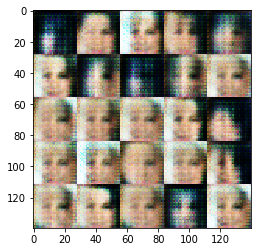

Epoch 1/1 - Batch 300/6331:  Discriminator Loss: 0.8769... Generator Loss: 2.0282
Epoch 1/1 - Batch 310/6331:  Discriminator Loss: 0.7116... Generator Loss: 2.9338
Epoch 1/1 - Batch 320/6331:  Discriminator Loss: 0.8527... Generator Loss: 4.1983
Epoch 1/1 - Batch 330/6331:  Discriminator Loss: 1.0132... Generator Loss: 2.6176
Epoch 1/1 - Batch 340/6331:  Discriminator Loss: 0.9366... Generator Loss: 3.1803
Epoch 1/1 - Batch 350/6331:  Discriminator Loss: 0.4932... Generator Loss: 3.1766
Epoch 1/1 - Batch 360/6331:  Discriminator Loss: 0.7335... Generator Loss: 1.5866
Epoch 1/1 - Batch 370/6331:  Discriminator Loss: 0.7966... Generator Loss: 2.3554
Epoch 1/1 - Batch 380/6331:  Discriminator Loss: 1.6609... Generator Loss: 4.4438
Epoch 1/1 - Batch 390/6331:  Discriminator Loss: 1.6796... Generator Loss: 0.4312


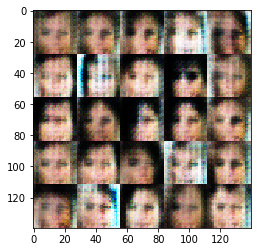

Epoch 1/1 - Batch 400/6331:  Discriminator Loss: 0.9104... Generator Loss: 1.1867
Epoch 1/1 - Batch 410/6331:  Discriminator Loss: 1.1145... Generator Loss: 3.2409
Epoch 1/1 - Batch 420/6331:  Discriminator Loss: 0.7686... Generator Loss: 1.9117
Epoch 1/1 - Batch 430/6331:  Discriminator Loss: 0.7883... Generator Loss: 1.4329
Epoch 1/1 - Batch 440/6331:  Discriminator Loss: 1.3743... Generator Loss: 0.5898
Epoch 1/1 - Batch 450/6331:  Discriminator Loss: 1.2665... Generator Loss: 0.6639
Epoch 1/1 - Batch 460/6331:  Discriminator Loss: 0.8508... Generator Loss: 1.9650
Epoch 1/1 - Batch 470/6331:  Discriminator Loss: 0.7867... Generator Loss: 1.6892
Epoch 1/1 - Batch 480/6331:  Discriminator Loss: 1.0855... Generator Loss: 0.9019
Epoch 1/1 - Batch 490/6331:  Discriminator Loss: 1.1772... Generator Loss: 0.8266


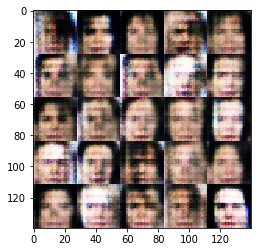

Epoch 1/1 - Batch 500/6331:  Discriminator Loss: 0.9311... Generator Loss: 1.1612
Epoch 1/1 - Batch 510/6331:  Discriminator Loss: 0.9882... Generator Loss: 0.9263
Epoch 1/1 - Batch 520/6331:  Discriminator Loss: 0.8624... Generator Loss: 2.4524
Epoch 1/1 - Batch 530/6331:  Discriminator Loss: 0.9246... Generator Loss: 1.1879
Epoch 1/1 - Batch 540/6331:  Discriminator Loss: 0.7049... Generator Loss: 2.0085
Epoch 1/1 - Batch 550/6331:  Discriminator Loss: 0.6719... Generator Loss: 2.1276
Epoch 1/1 - Batch 560/6331:  Discriminator Loss: 1.2193... Generator Loss: 0.7586
Epoch 1/1 - Batch 570/6331:  Discriminator Loss: 1.1806... Generator Loss: 0.7448
Epoch 1/1 - Batch 580/6331:  Discriminator Loss: 0.6868... Generator Loss: 1.6619
Epoch 1/1 - Batch 590/6331:  Discriminator Loss: 1.8879... Generator Loss: 0.3680


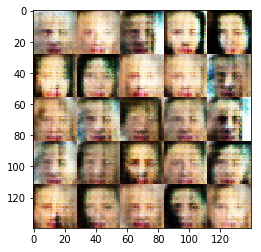

Epoch 1/1 - Batch 600/6331:  Discriminator Loss: 1.1486... Generator Loss: 0.8605
Epoch 1/1 - Batch 610/6331:  Discriminator Loss: 0.6766... Generator Loss: 1.8246
Epoch 1/1 - Batch 620/6331:  Discriminator Loss: 1.3951... Generator Loss: 0.7149
Epoch 1/1 - Batch 630/6331:  Discriminator Loss: 0.7490... Generator Loss: 1.5163
Epoch 1/1 - Batch 640/6331:  Discriminator Loss: 0.8596... Generator Loss: 1.8276
Epoch 1/1 - Batch 650/6331:  Discriminator Loss: 0.9830... Generator Loss: 1.1055
Epoch 1/1 - Batch 660/6331:  Discriminator Loss: 1.2253... Generator Loss: 0.7519
Epoch 1/1 - Batch 670/6331:  Discriminator Loss: 0.9398... Generator Loss: 1.2253
Epoch 1/1 - Batch 680/6331:  Discriminator Loss: 1.2276... Generator Loss: 0.6660
Epoch 1/1 - Batch 690/6331:  Discriminator Loss: 0.8667... Generator Loss: 1.2850


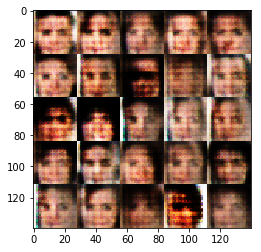

Epoch 1/1 - Batch 700/6331:  Discriminator Loss: 0.9890... Generator Loss: 1.0544
Epoch 1/1 - Batch 710/6331:  Discriminator Loss: 0.7964... Generator Loss: 1.2937
Epoch 1/1 - Batch 720/6331:  Discriminator Loss: 1.0826... Generator Loss: 0.7498
Epoch 1/1 - Batch 730/6331:  Discriminator Loss: 1.1821... Generator Loss: 0.8136
Epoch 1/1 - Batch 740/6331:  Discriminator Loss: 0.9144... Generator Loss: 1.1812
Epoch 1/1 - Batch 750/6331:  Discriminator Loss: 1.1684... Generator Loss: 0.7666
Epoch 1/1 - Batch 760/6331:  Discriminator Loss: 1.5506... Generator Loss: 0.6052
Epoch 1/1 - Batch 770/6331:  Discriminator Loss: 0.7312... Generator Loss: 1.9990
Epoch 1/1 - Batch 780/6331:  Discriminator Loss: 1.3595... Generator Loss: 0.6067
Epoch 1/1 - Batch 790/6331:  Discriminator Loss: 0.9610... Generator Loss: 1.0622


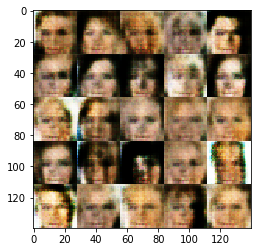

Epoch 1/1 - Batch 800/6331:  Discriminator Loss: 0.8970... Generator Loss: 2.1394
Epoch 1/1 - Batch 810/6331:  Discriminator Loss: 1.1537... Generator Loss: 2.4915
Epoch 1/1 - Batch 820/6331:  Discriminator Loss: 1.1900... Generator Loss: 0.7685
Epoch 1/1 - Batch 830/6331:  Discriminator Loss: 1.2496... Generator Loss: 0.7672
Epoch 1/1 - Batch 840/6331:  Discriminator Loss: 1.2012... Generator Loss: 0.7919
Epoch 1/1 - Batch 850/6331:  Discriminator Loss: 0.9996... Generator Loss: 1.0335
Epoch 1/1 - Batch 860/6331:  Discriminator Loss: 0.6703... Generator Loss: 1.7446
Epoch 1/1 - Batch 870/6331:  Discriminator Loss: 0.8659... Generator Loss: 1.6510
Epoch 1/1 - Batch 880/6331:  Discriminator Loss: 0.8117... Generator Loss: 1.6465
Epoch 1/1 - Batch 890/6331:  Discriminator Loss: 0.8898... Generator Loss: 1.8167


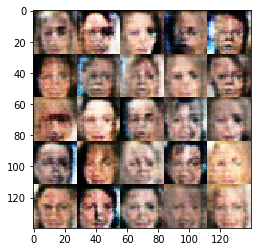

Epoch 1/1 - Batch 900/6331:  Discriminator Loss: 1.3078... Generator Loss: 0.6619
Epoch 1/1 - Batch 910/6331:  Discriminator Loss: 0.7381... Generator Loss: 2.3970
Epoch 1/1 - Batch 920/6331:  Discriminator Loss: 0.8161... Generator Loss: 1.4262
Epoch 1/1 - Batch 930/6331:  Discriminator Loss: 0.9739... Generator Loss: 0.9075
Epoch 1/1 - Batch 940/6331:  Discriminator Loss: 0.9135... Generator Loss: 1.2372
Epoch 1/1 - Batch 950/6331:  Discriminator Loss: 0.8591... Generator Loss: 1.3289
Epoch 1/1 - Batch 960/6331:  Discriminator Loss: 0.7429... Generator Loss: 2.2926
Epoch 1/1 - Batch 970/6331:  Discriminator Loss: 1.7541... Generator Loss: 0.4136
Epoch 1/1 - Batch 980/6331:  Discriminator Loss: 0.8526... Generator Loss: 1.1544
Epoch 1/1 - Batch 990/6331:  Discriminator Loss: 0.8317... Generator Loss: 1.4567


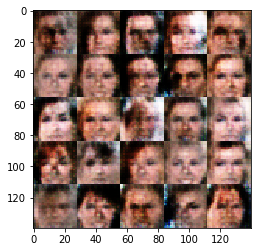

Epoch 1/1 - Batch 1000/6331:  Discriminator Loss: 1.4183... Generator Loss: 1.3937
Epoch 1/1 - Batch 1010/6331:  Discriminator Loss: 0.8313... Generator Loss: 2.0111
Epoch 1/1 - Batch 1020/6331:  Discriminator Loss: 1.1222... Generator Loss: 0.7827
Epoch 1/1 - Batch 1030/6331:  Discriminator Loss: 0.8649... Generator Loss: 2.2071
Epoch 1/1 - Batch 1040/6331:  Discriminator Loss: 1.1457... Generator Loss: 0.7855
Epoch 1/1 - Batch 1050/6331:  Discriminator Loss: 0.9485... Generator Loss: 0.9748
Epoch 1/1 - Batch 1060/6331:  Discriminator Loss: 0.9569... Generator Loss: 1.1071
Epoch 1/1 - Batch 1070/6331:  Discriminator Loss: 1.3038... Generator Loss: 3.2274
Epoch 1/1 - Batch 1080/6331:  Discriminator Loss: 0.8686... Generator Loss: 2.7095
Epoch 1/1 - Batch 1090/6331:  Discriminator Loss: 0.7938... Generator Loss: 2.0575


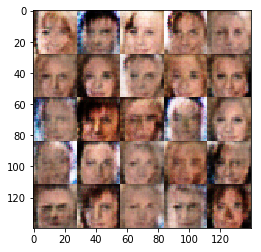

Epoch 1/1 - Batch 1100/6331:  Discriminator Loss: 1.2129... Generator Loss: 0.6744
Epoch 1/1 - Batch 1110/6331:  Discriminator Loss: 0.9960... Generator Loss: 1.0072
Epoch 1/1 - Batch 1120/6331:  Discriminator Loss: 0.9845... Generator Loss: 1.0581
Epoch 1/1 - Batch 1130/6331:  Discriminator Loss: 1.0327... Generator Loss: 0.9413
Epoch 1/1 - Batch 1140/6331:  Discriminator Loss: 1.1143... Generator Loss: 1.2168
Epoch 1/1 - Batch 1150/6331:  Discriminator Loss: 0.9102... Generator Loss: 1.8711
Epoch 1/1 - Batch 1160/6331:  Discriminator Loss: 0.9640... Generator Loss: 1.2247
Epoch 1/1 - Batch 1170/6331:  Discriminator Loss: 0.9034... Generator Loss: 1.9650
Epoch 1/1 - Batch 1180/6331:  Discriminator Loss: 0.7681... Generator Loss: 1.4944
Epoch 1/1 - Batch 1190/6331:  Discriminator Loss: 1.0254... Generator Loss: 0.8019


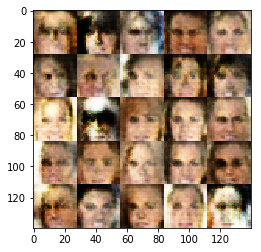

Epoch 1/1 - Batch 1200/6331:  Discriminator Loss: 0.8218... Generator Loss: 2.0905
Epoch 1/1 - Batch 1210/6331:  Discriminator Loss: 0.6670... Generator Loss: 1.4210
Epoch 1/1 - Batch 1220/6331:  Discriminator Loss: 0.8462... Generator Loss: 1.5716
Epoch 1/1 - Batch 1230/6331:  Discriminator Loss: 0.8550... Generator Loss: 1.3373
Epoch 1/1 - Batch 1240/6331:  Discriminator Loss: 1.0311... Generator Loss: 0.8463
Epoch 1/1 - Batch 1250/6331:  Discriminator Loss: 0.8989... Generator Loss: 1.3481
Epoch 1/1 - Batch 1260/6331:  Discriminator Loss: 1.3779... Generator Loss: 0.5553
Epoch 1/1 - Batch 1270/6331:  Discriminator Loss: 1.2232... Generator Loss: 3.4369
Epoch 1/1 - Batch 1280/6331:  Discriminator Loss: 1.2630... Generator Loss: 0.7926
Epoch 1/1 - Batch 1290/6331:  Discriminator Loss: 0.7790... Generator Loss: 1.3697


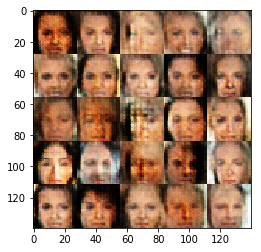

Epoch 1/1 - Batch 1300/6331:  Discriminator Loss: 1.1320... Generator Loss: 0.8532
Epoch 1/1 - Batch 1310/6331:  Discriminator Loss: 0.8499... Generator Loss: 1.2824
Epoch 1/1 - Batch 1320/6331:  Discriminator Loss: 1.0802... Generator Loss: 0.9483
Epoch 1/1 - Batch 1330/6331:  Discriminator Loss: 1.0982... Generator Loss: 0.8656
Epoch 1/1 - Batch 1340/6331:  Discriminator Loss: 1.1534... Generator Loss: 2.0463
Epoch 1/1 - Batch 1350/6331:  Discriminator Loss: 0.8498... Generator Loss: 1.5619
Epoch 1/1 - Batch 1360/6331:  Discriminator Loss: 0.9598... Generator Loss: 2.2206
Epoch 1/1 - Batch 1370/6331:  Discriminator Loss: 1.0459... Generator Loss: 0.8737
Epoch 1/1 - Batch 1380/6331:  Discriminator Loss: 1.0514... Generator Loss: 0.9653
Epoch 1/1 - Batch 1390/6331:  Discriminator Loss: 0.7281... Generator Loss: 1.6734


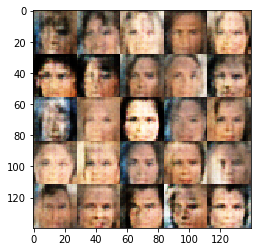

Epoch 1/1 - Batch 1400/6331:  Discriminator Loss: 1.0787... Generator Loss: 0.8653
Epoch 1/1 - Batch 1410/6331:  Discriminator Loss: 0.9726... Generator Loss: 1.0048
Epoch 1/1 - Batch 1420/6331:  Discriminator Loss: 1.1098... Generator Loss: 1.9917
Epoch 1/1 - Batch 1430/6331:  Discriminator Loss: 1.2637... Generator Loss: 0.5942
Epoch 1/1 - Batch 1440/6331:  Discriminator Loss: 1.2192... Generator Loss: 0.6627
Epoch 1/1 - Batch 1450/6331:  Discriminator Loss: 0.9156... Generator Loss: 1.5937
Epoch 1/1 - Batch 1460/6331:  Discriminator Loss: 1.1423... Generator Loss: 2.1394
Epoch 1/1 - Batch 1470/6331:  Discriminator Loss: 1.0694... Generator Loss: 0.9258
Epoch 1/1 - Batch 1480/6331:  Discriminator Loss: 0.9407... Generator Loss: 1.7743
Epoch 1/1 - Batch 1490/6331:  Discriminator Loss: 0.8392... Generator Loss: 1.9107


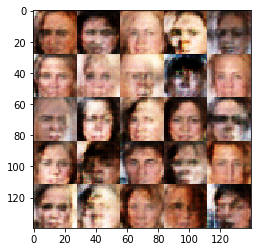

Epoch 1/1 - Batch 1500/6331:  Discriminator Loss: 1.2255... Generator Loss: 0.6796
Epoch 1/1 - Batch 1510/6331:  Discriminator Loss: 1.0471... Generator Loss: 1.2373
Epoch 1/1 - Batch 1520/6331:  Discriminator Loss: 1.1935... Generator Loss: 2.3894
Epoch 1/1 - Batch 1530/6331:  Discriminator Loss: 1.0644... Generator Loss: 0.8740
Epoch 1/1 - Batch 1540/6331:  Discriminator Loss: 0.9877... Generator Loss: 0.9211
Epoch 1/1 - Batch 1550/6331:  Discriminator Loss: 1.1010... Generator Loss: 0.9224
Epoch 1/1 - Batch 1560/6331:  Discriminator Loss: 0.9960... Generator Loss: 1.0014
Epoch 1/1 - Batch 1570/6331:  Discriminator Loss: 1.0888... Generator Loss: 1.8081
Epoch 1/1 - Batch 1580/6331:  Discriminator Loss: 0.9188... Generator Loss: 1.0176
Epoch 1/1 - Batch 1590/6331:  Discriminator Loss: 0.8013... Generator Loss: 1.5109


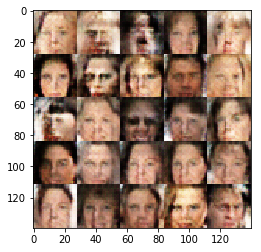

Epoch 1/1 - Batch 1600/6331:  Discriminator Loss: 0.9898... Generator Loss: 0.9451
Epoch 1/1 - Batch 1610/6331:  Discriminator Loss: 1.0123... Generator Loss: 1.5483
Epoch 1/1 - Batch 1620/6331:  Discriminator Loss: 0.9599... Generator Loss: 1.1545
Epoch 1/1 - Batch 1630/6331:  Discriminator Loss: 1.0276... Generator Loss: 1.0194
Epoch 1/1 - Batch 1640/6331:  Discriminator Loss: 1.5282... Generator Loss: 3.6981
Epoch 1/1 - Batch 1650/6331:  Discriminator Loss: 0.9817... Generator Loss: 0.9089
Epoch 1/1 - Batch 1660/6331:  Discriminator Loss: 0.9348... Generator Loss: 1.1500
Epoch 1/1 - Batch 1670/6331:  Discriminator Loss: 1.4290... Generator Loss: 0.5128
Epoch 1/1 - Batch 1680/6331:  Discriminator Loss: 1.0946... Generator Loss: 0.8610
Epoch 1/1 - Batch 1690/6331:  Discriminator Loss: 1.3011... Generator Loss: 0.6599


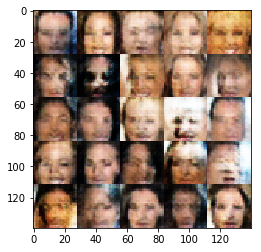

Epoch 1/1 - Batch 1700/6331:  Discriminator Loss: 1.1355... Generator Loss: 0.8461
Epoch 1/1 - Batch 1710/6331:  Discriminator Loss: 0.8689... Generator Loss: 1.4469
Epoch 1/1 - Batch 1720/6331:  Discriminator Loss: 1.1562... Generator Loss: 0.7129
Epoch 1/1 - Batch 1730/6331:  Discriminator Loss: 0.8089... Generator Loss: 1.9232
Epoch 1/1 - Batch 1740/6331:  Discriminator Loss: 0.8783... Generator Loss: 1.1188
Epoch 1/1 - Batch 1750/6331:  Discriminator Loss: 0.9864... Generator Loss: 1.5486
Epoch 1/1 - Batch 1760/6331:  Discriminator Loss: 0.8728... Generator Loss: 1.2845
Epoch 1/1 - Batch 1770/6331:  Discriminator Loss: 1.0111... Generator Loss: 2.4422
Epoch 1/1 - Batch 1780/6331:  Discriminator Loss: 1.2510... Generator Loss: 0.6478
Epoch 1/1 - Batch 1790/6331:  Discriminator Loss: 0.8879... Generator Loss: 1.1682


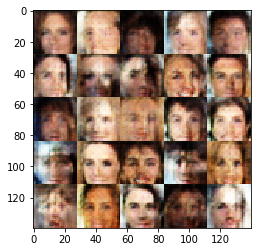

Epoch 1/1 - Batch 1800/6331:  Discriminator Loss: 1.3343... Generator Loss: 0.5817
Epoch 1/1 - Batch 1810/6331:  Discriminator Loss: 0.6817... Generator Loss: 1.8006
Epoch 1/1 - Batch 1820/6331:  Discriminator Loss: 1.0682... Generator Loss: 0.8466
Epoch 1/1 - Batch 1830/6331:  Discriminator Loss: 1.0188... Generator Loss: 0.9432
Epoch 1/1 - Batch 1840/6331:  Discriminator Loss: 0.8033... Generator Loss: 1.3437
Epoch 1/1 - Batch 1850/6331:  Discriminator Loss: 1.0089... Generator Loss: 0.8907
Epoch 1/1 - Batch 1860/6331:  Discriminator Loss: 0.8298... Generator Loss: 1.4031
Epoch 1/1 - Batch 1870/6331:  Discriminator Loss: 0.8891... Generator Loss: 1.7565
Epoch 1/1 - Batch 1880/6331:  Discriminator Loss: 1.7701... Generator Loss: 0.3367
Epoch 1/1 - Batch 1890/6331:  Discriminator Loss: 0.9274... Generator Loss: 2.1252


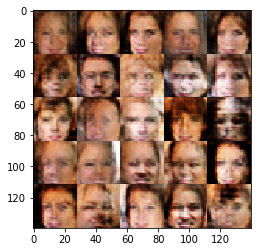

Epoch 1/1 - Batch 1900/6331:  Discriminator Loss: 1.0489... Generator Loss: 0.8958
Epoch 1/1 - Batch 1910/6331:  Discriminator Loss: 0.8265... Generator Loss: 1.8041
Epoch 1/1 - Batch 1920/6331:  Discriminator Loss: 1.0018... Generator Loss: 2.1142
Epoch 1/1 - Batch 1930/6331:  Discriminator Loss: 0.9070... Generator Loss: 1.2348
Epoch 1/1 - Batch 1940/6331:  Discriminator Loss: 1.1325... Generator Loss: 0.8203
Epoch 1/1 - Batch 1950/6331:  Discriminator Loss: 0.7611... Generator Loss: 1.5677
Epoch 1/1 - Batch 1960/6331:  Discriminator Loss: 0.9784... Generator Loss: 0.9277
Epoch 1/1 - Batch 1970/6331:  Discriminator Loss: 0.9634... Generator Loss: 1.0211
Epoch 1/1 - Batch 1980/6331:  Discriminator Loss: 1.0113... Generator Loss: 0.8750
Epoch 1/1 - Batch 1990/6331:  Discriminator Loss: 1.0426... Generator Loss: 1.3968


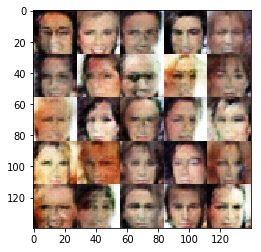

Epoch 1/1 - Batch 2000/6331:  Discriminator Loss: 1.0433... Generator Loss: 0.8637
Epoch 1/1 - Batch 2010/6331:  Discriminator Loss: 1.1750... Generator Loss: 0.6828


KeyboardInterrupt: 

In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.